In [1]:
import yfinance as yf
from arch import arch_model
from arch.__future__ import reindexing
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

ticker= "aapl"
stock_data = yf.download(ticker, start="2016-01-04", end="2022-10-26")

[*********************100%***********************]  1 of 1 completed


In [2]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.151489,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.546274,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.085484,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.111166,324377600
2016-01-08,24.637501,24.777500,24.190001,24.240000,22.228085,283192000


In [3]:
stock_data['Return'] = 100 * (stock_data['Close'].pct_change())

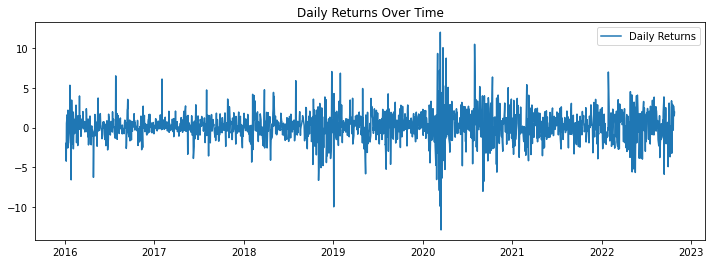

In [4]:
stock_data.dropna(inplace=True)

fig = plt.figure()
fig.set_figwidth(12)
plt.plot(stock_data['Return'], label = 'Daily Returns')
plt.legend(loc='upper right')
plt.title('Daily Returns Over Time')
plt.show()

In [5]:
daily_volatility = stock_data['Return'].std()
print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))

monthly_volatility = math.sqrt(21) * daily_volatility
print ('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))

annual_volatility = math.sqrt(252) * daily_volatility
print ('Annual volatility: ', '{:.2f}%'.format(annual_volatility ))

Daily volatility:  1.89%
Monthly volatility:  8.66%
Annual volatility:  30.01%


In [6]:
garch_model = arch_model(stock_data['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')

gm_result = garch_model.fit(disp='off')
print(gm_result.params)

print('\n')

gm_forecast = gm_result.forecast(horizon = 5)
print(gm_forecast.variance[-1:])

mu          0.205869
omega       0.164659
alpha[1]    0.126879
beta[1]     0.826458
Name: params, dtype: float64


                 h.1       h.2      h.3       h.4       h.5
Date                                                       
2022-10-25  3.596223  3.593073  3.59007  3.587208  3.584478


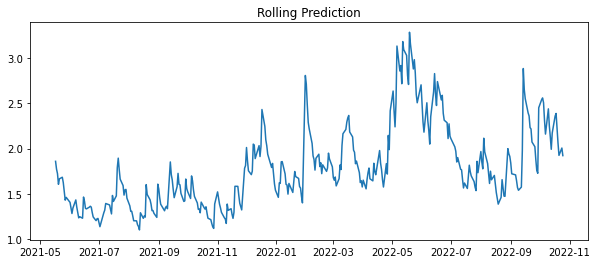

In [7]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = stock_data['Return'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=stock_data['Return'].index[-365:])

plt.figure(figsize=(10,4))
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')
plt.show()

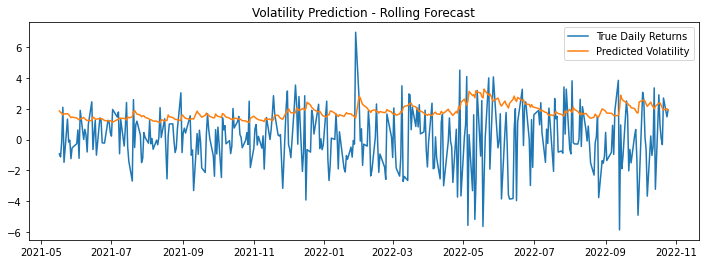

In [8]:
plt.figure(figsize=(12,4))
plt.plot(stock_data['Return'][-365:])
plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])
plt.show()